## Нейросеть для восстановления ряда из синтетического $\mathsf{sin}$

In [ ]:
from google.colab import drive
import pickle
from tqdm import tqdm_notebook

drive.mount("/content/drive")

In [ ]:
!pip install geotorch

In [ ]:
from drive.MyDrive.metric_analysis.modules.classes_and_functions import *
from drive.MyDrive.metric_analysis.modules.model_arch import *
from drive.MyDrive.metric_analysis.modules.visualization import *

$\mathbf{f}(x) = \sigma(w^{\mathsf{T}}\cdot \sigma(W^{\mathsf{T}}x + b_1) + b_2)$

$\ x \in \mathbb{R}^{h}, \ W \in \mathbb{R}^{h \times d}, \ b_1 \in \mathbb{R}^h, \ b_2 \in \mathbb{R}, \ w \in \mathbb{R}^d: w^Tw=1, WW^T=I.$

Здесь вопрос: восстанавливается ??? временного ряда.

Длина входа: 1% от длины сигнала (-> 100 батчей).
Длина выхода: 2% от длины сигнала.

Временной ряд $s \in [-1, 1]$.
Выходная активация $tanh$, промежуточная - $sigmoid$.


Генерируем временной ряд. Точки x берем из симметричного интервала. Параметром является случайный шум.

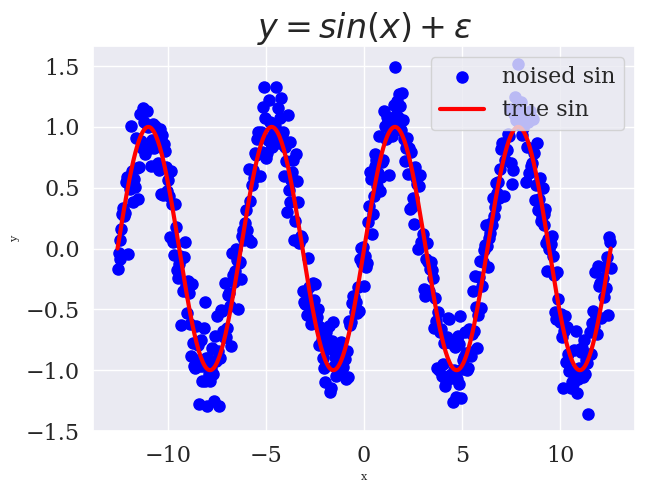

In [ ]:
sample_size = 500
window_scale = 4
noise_std = 0.2 # интенсивность шума

X, y_true, y = generate_noised_sin(sample_size, window_scale, noise_std, visualize=True)

### Для 3-х мерного пространства

Задаем архитектуру модели 20-3-20. Создаем датасет и даталоадер из временного ряда.

In [ ]:
in_len = 20
hid_dim = 3
out_len = 20

batch_size = 16
lr = 1e-3

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset = TimeSerie_1d_Dataset(in_len=in_len, out_len=out_len, s_noice=y, s_true=y_true)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = NN_2_orthogonal(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

cuda:0


Обучаем тестовую модель чтобы замерить номер эпохи, когда уже почти сошлась

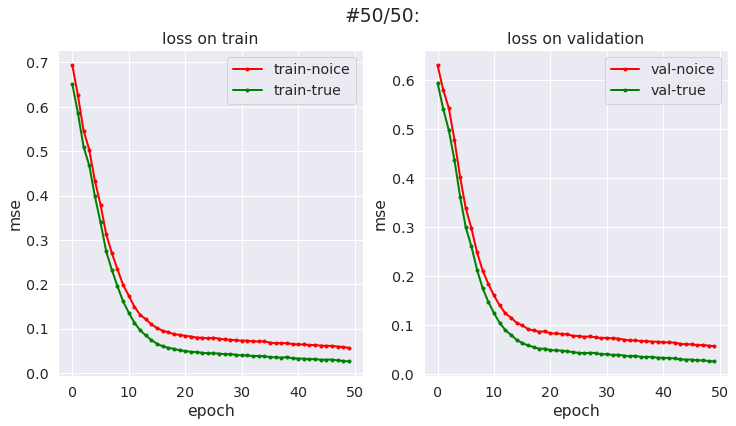

In [ ]:
model, optimizer, losses, losses_true = learning_loop(
    model = model,
    optimizer = optimizer,
    loader = dataloader,
    criterion = criterion,
    epochs = 50,
    draw_every=10,
    separate_show=True,
    device=device
)

Визуализируем результат восстановления обученной модели.

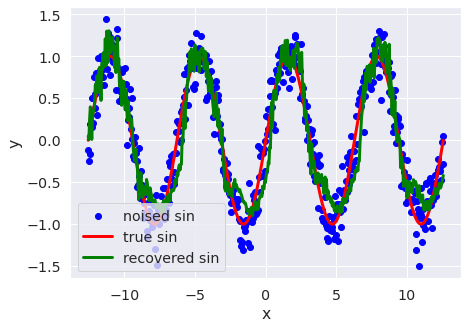

In [ ]:
visualize_predictions(X, y, y_true, model, dataset, batch_size, device='cuda')

Запускаем тренировку $N=100$ моделей на $max_epoch=25$ эпох. Сохраняем эти модели на гугл-диск.

In [ ]:
path = '/content/drive/MyDrive/metric_analysis/2NN_experiment_3d'
N = 100
max_epochs = 25

In [ ]:
# Обучение моделей

models = []
losses = []

for i in tqdm_notebook(range(N)):
    model = NN_2_orthogonal(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model, optimizer, losses_tr, losses_true_tr = learning_loop(
        model = model,
        optimizer = optimizer,
        loader = dataloader,
        criterion = criterion,
        epochs = max_epochs,
        val_every=max_epochs+1, 
        draw_every=max_epochs+1,
        separate_show=True,
        device=device
    )

    models.append(model)
    losses.append(losses_true_tr['train'][-1])
    print(f'Loss #{i + 1}: {losses_true_tr["train"][-1]:.3f}')

    torch.save(model.state_dict(), path + f"/nn_{i + 1}.pth")

Загружаем веса $\mathbf{W}_1$ модели из гугл-диска. !!!  нам нужна W2!!!

In [ ]:
# загрузка моделей

models = []

for i in range(1, N + 1):
    model = NN_2_orthogonal(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
    model.load_state_dict(torch.load(path + f'/nn_{i}.pth'))
    models.append(model)

In [ ]:
models[0]

NN_2_orthogonal(
  (W1): ParametrizedLinear(
    in_features=20, out_features=3, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): Stiefel(n=20, k=3, triv=linalg_matrix_exp, transposed)
      )
    )
  )
  (act1): ReLU()
  (W2): Linear(in_features=3, out_features=20, bias=True)
  (act2): Identity()
)

нам нужны веса W1 (так как на выходе 20 -> 20 строк по 3 элемента)

In [ ]:
W1_matrices = np.array([models[i].W1.weight.detach().cpu().numpy() for i in range(len(models))])
print(W1_matrices.shape)

means = W1_matrices.mean(axis=0).T
variances = np.array([np.cov(W1_matrices[:, :, i], rowvar=False) for i in range(in_len)])
correlations = np.array([np.corrcoef(W1_matrices[:, :, i], rowvar=False) for i in range(in_len)])
print(means.shape, variances.shape)

(100, 3, 20)
(20, 3) (20, 3, 3)


In [ ]:
def plot_cov_heatmap(variances, path_to_save=None, img_name=None):
    n_neurons = variances.shape[0]
    grid_len = int(np.ceil(np.sqrt(n_neurons)))

    fig, axes = plt.subplots(grid_len, grid_len, figsize=(5 * grid_len, 5 * grid_len))
    fig.suptitle('Cov of neurons')

    for i in range(grid_len):
        for j in range(grid_len):
            n_neu = i * grid_len + j + 1
            if n_neu > n_neurons:
                break
            axes[i, j].set_title(f'Neu #{n_neu}')
            sns.heatmap(variances[n_neu-1], annot=True, fmt=".2f", cbar=False, ax=axes[i, j])        

    
    if path_to_save is not None:
        plt.savefig(path_to_save + '/' + img_name + '_var_hm.jpg')

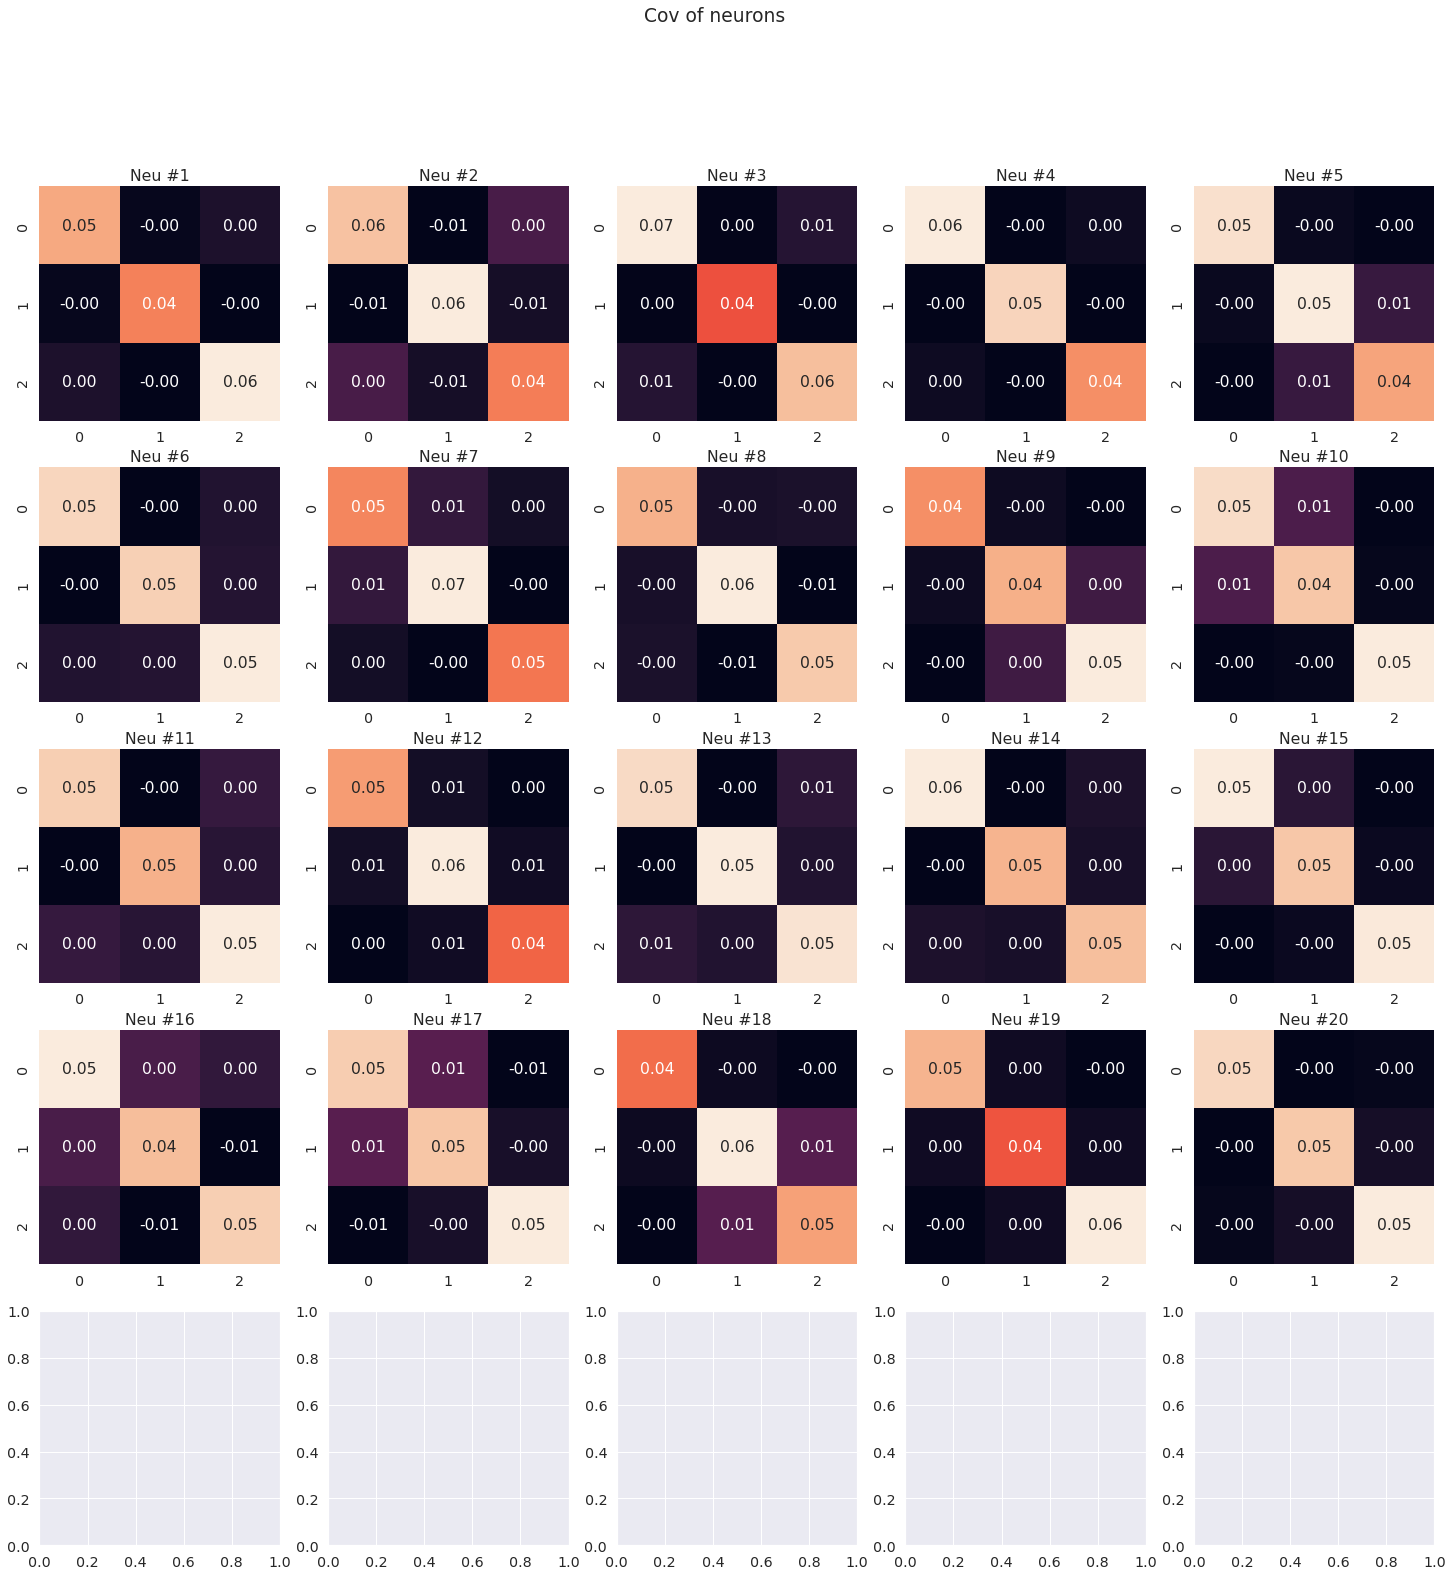

In [ ]:
plot_cov_heatmap(variances, path_to_save='/content/drive/MyDrive/metric_analysis/plots/2nn', 
                  img_name='3d_var_20_3_20_normal')

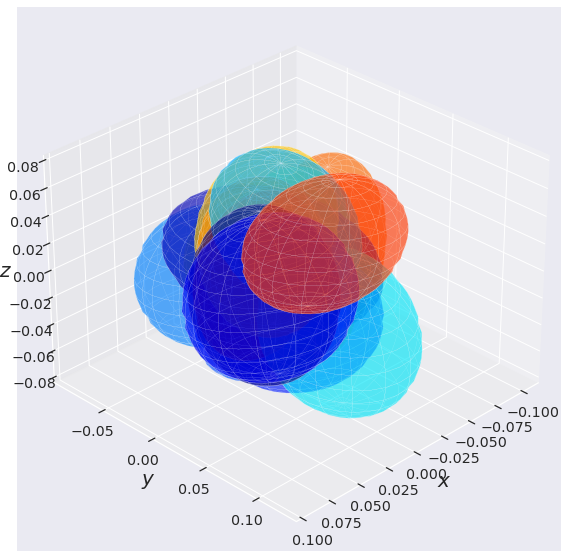

In [ ]:
plot_3d_gaussians(means, variances, alpha=1,
                  path_to_save='/content/drive/MyDrive/metric_analysis/plots/2nn', 
                  img_name='3d_var_20_3_20_normal_alpha=1')

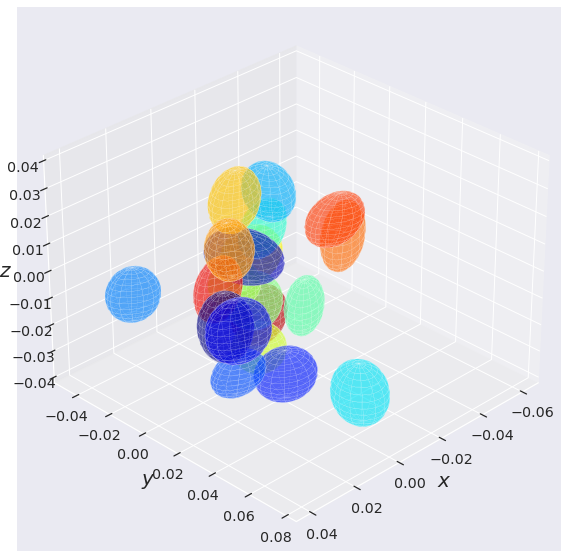

In [ ]:
plot_3d_gaussians(means, variances, alpha=0.2,
                  path_to_save='/content/drive/MyDrive/metric_analysis/plots/2nn', 
                  img_name='3d_var_20_3_20_normal_alpha=0.2')

### Теперь восстановление 20, а даем на вход 10

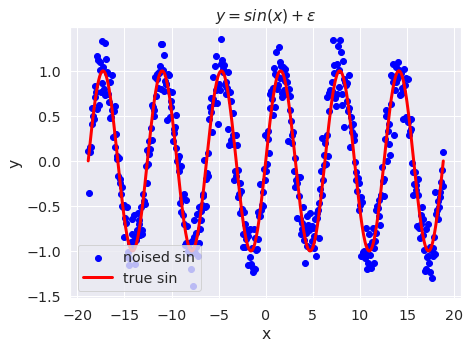

In [ ]:
sample_size = 500
window_scale = 6
noise_std = 0.2 # интенсивность шума

X, y_true, y = generate_noised_sin(sample_size, window_scale, noise_std, visualize=True)

In [ ]:
path = '/content/drive/MyDrive/metric_analysis/2NN_experiment2NN_10_3_20'

in_len = 10
hid_dim = 3
out_len = 20

batch_size = 16
lr = 1e-3

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset = TimeSerie_1d_Dataset(in_len=in_len, out_len=out_len, s_noice=y, s_true=y_true)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = NN_2_orthogonal(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

cuda:0


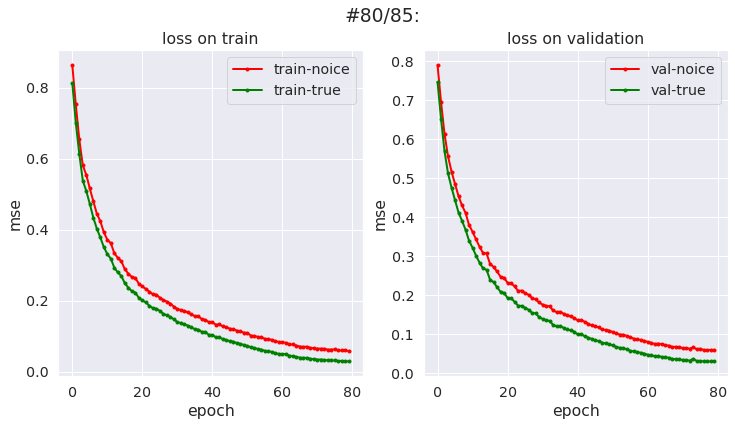

In [ ]:
model, optimizer, losses, losses_true = learning_loop(
    model = model,
    optimizer = optimizer,
    loader = dataloader,
    criterion = criterion,
    epochs = 85,
    draw_every = 10,
    separate_show = True,
    device = device
)

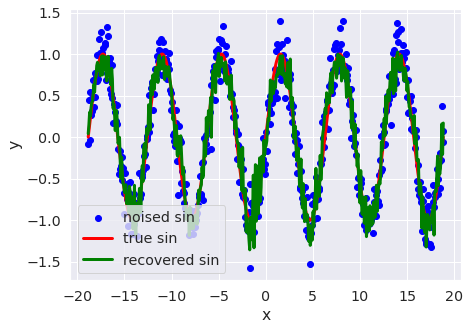

In [ ]:
visualize_predictions(X, y, y_true, model, dataset, batch_size, device)

70 эпох достаточно

In [ ]:
N = 100
max_epochs = 70

models = []
losses = []

for i in tqdm_notebook(range(N)):
    model = NN_2_orthogonal(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model, optimizer, losses_tr, losses_true_tr = learning_loop(
        model = model,
        optimizer = optimizer,
        loader = dataloader,
        criterion = criterion,
        epochs = max_epochs,
        val_every=max_epochs+1, 
        draw_every=max_epochs+1,
        separate_show=True,
        device=device
    )

    models.append(model)
    losses.append(losses_true_tr['train'][-1])
    print(f'Loss #{i + 1}: {losses_true_tr["train"][-1]:.3f}')

    torch.save(model.state_dict(), path + f"/nn_{i + 1}.pth")

In [ ]:
# загрузка моделей
models = []

for i in range(1, N + 1):
    model = NN_2_orthogonal(in_len=in_len, hid_dim=hid_dim, out_len=out_len).to(device)
    model.load_state_dict(torch.load(path + f'/nn_{i}.pth'))
    models.append(model)

In [ ]:
models[0]

NN_2_orthogonal(
  (W1): ParametrizedLinear(
    in_features=10, out_features=3, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): Stiefel(n=10, k=3, triv=linalg_matrix_exp, transposed)
      )
    )
  )
  (act1): ReLU()
  (W2): Linear(in_features=3, out_features=20, bias=True)
  (act2): Identity()
)

In [ ]:
W1_matrices.shape

(100, 3, 10)

In [ ]:
W1_matrices = np.array([models[i].W1.weight.detach().cpu().numpy() for i in range(len(models))])
print(W1_matrices.shape)

means = W1_matrices.mean(axis=0).T
variances = np.array([np.cov(W1_matrices[:, :, i], rowvar=False) for i in range(in_len)])
correlations = np.array([np.corrcoef(W1_matrices[:, :, i], rowvar=False) for i in range(in_len)])
print(means.shape, variances.shape)

(100, 3, 10)
(10, 3) (10, 3, 3)


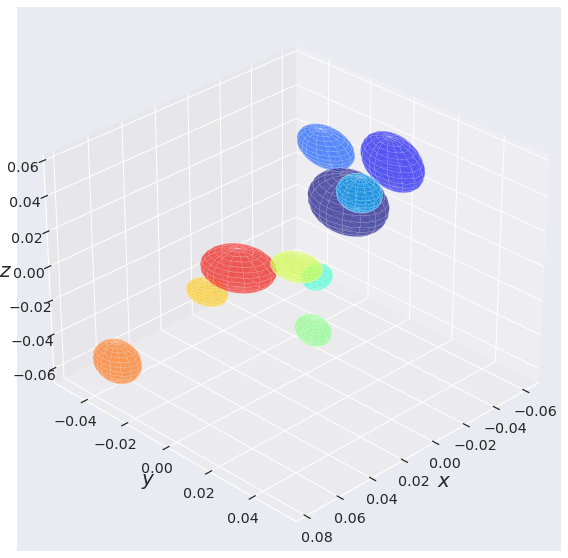

In [ ]:
plot_3d_gaussians(means, variances, alpha=0.1, 
                  path_to_save='/content/drive/MyDrive/metric_analysis/plots/2nn', 
                  img_name='3d_var_10_3_20_alpha=0.1')

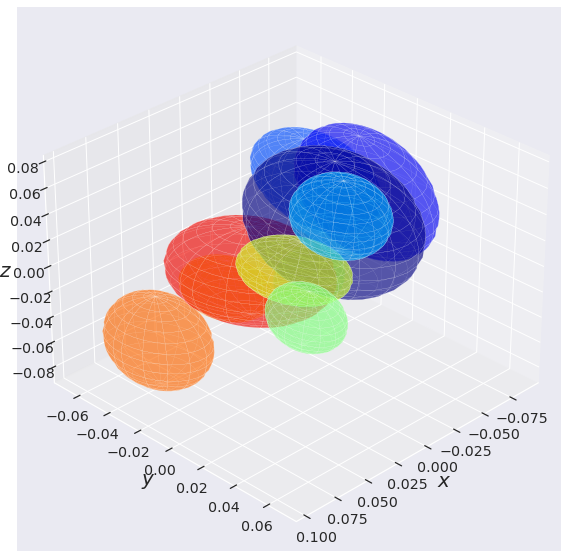

In [ ]:
plot_3d_gaussians(means, variances, alpha=0.3, 
                  path_to_save='/content/drive/MyDrive/metric_analysis/plots/2nn', 
                  img_name='3d_var_10_3_20_alpha=0.3')

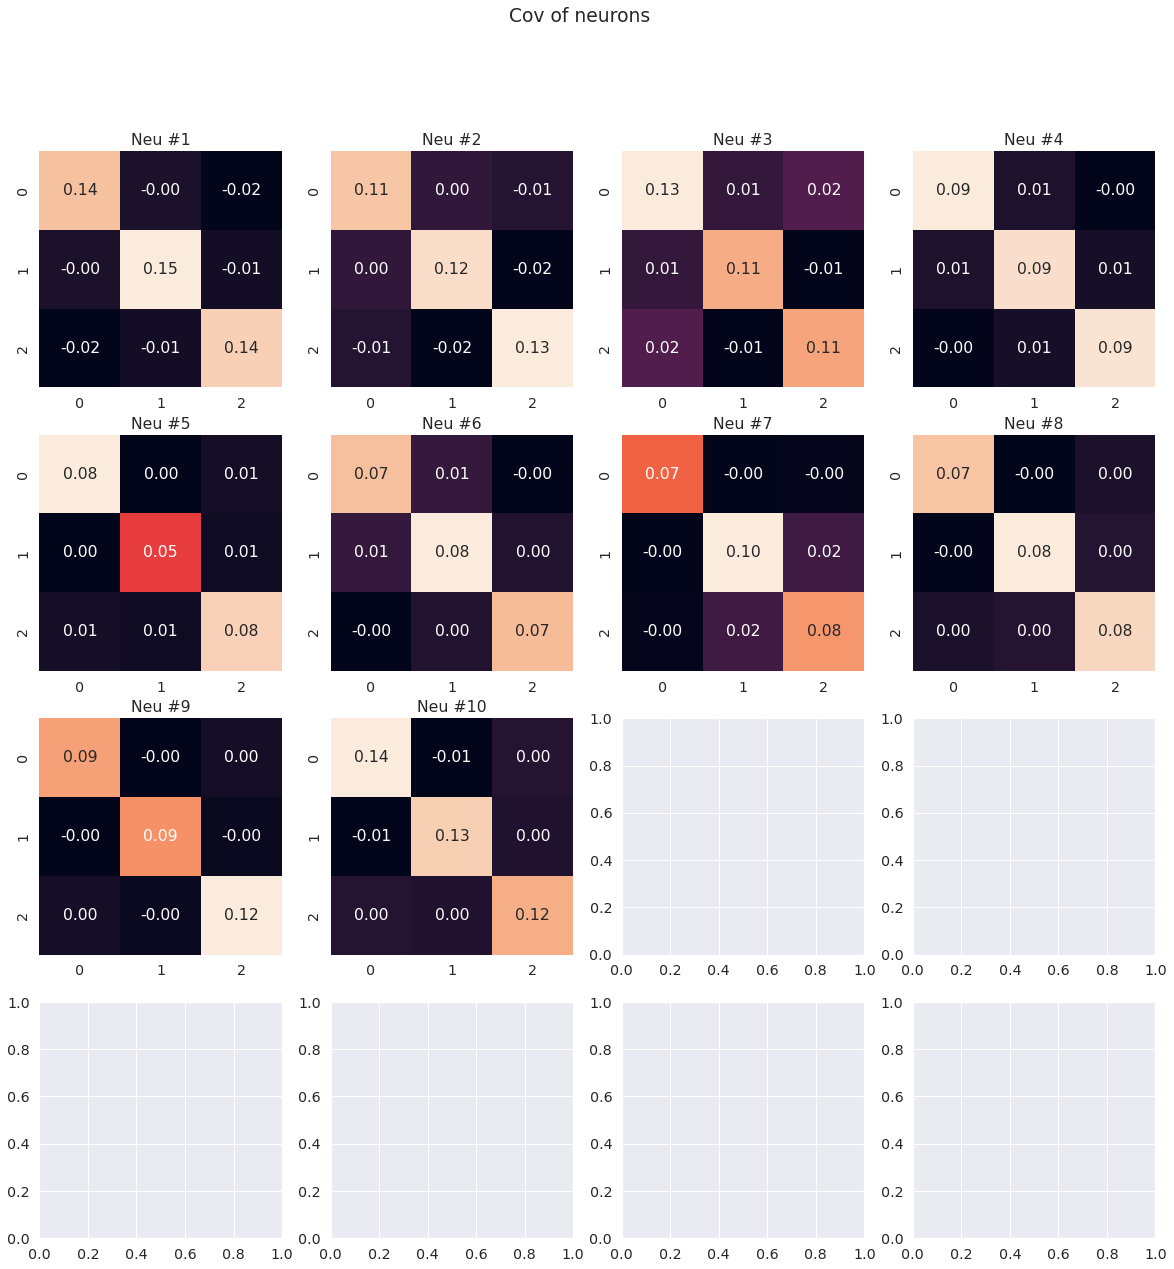

In [ ]:
plot_cov_heatmap(variances, path_to_save='/content/drive/MyDrive/metric_analysis/plots/2nn', 
                  img_name='3d_var_10_3_20_alpha=0.3')

In [ ]:
plot_3d_gaussians_rot(means, variances, alpha=0.3, path_to_save='/content/drive/MyDrive/metric_analysis/plots/2nn', 
                  img_name='3d_var_10_3_20_alpha=0.3')